## Immersive Data Analytics - Capstone Project 

####  Laura   Adam,  Kiran Pandey,  Leo Reos  May 9, 2019

#### Project title:  Mobility, Household Income and Wealth

#### Project objectives:  Determine the extent to which Mobility affects household income and 
#### whether access to insurance increases mobility among households 

### Libarries Used 

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn

from sklearn.cluster import KMeans  #algorithm in sklearn library to do k-means clustering
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import tree
import seaborn as sns

import statsmodels.api as sm

import statsmodels.formula.api as smf

###  Load input data 
##### Source:  Health and Retirement Study available at https://hrs.isr.umich.edu/data-products
#### selected variables extracted fron stata format to xls file
#####  * variables extracted in three batches for 1) mobility 2) income and wealth and 3) insurance 
#####  * only obseravation for wave12 (2014)  were extracted
##### * hhidpn uniquesly identifies each observation in the dataset 

In [3]:
np.set_printoptions(precision=2,suppress=True)              # set print options to suppress small numbers
#pd.set_option("display.precision",4)

In [4]:
Location = "IDA_CAPSTONE_MAY9.xlsx"

df1 = pd.read_excel(Location,sheet_name='final_project')          # 
df2 = pd.read_excel(Location,sheet_name='Mobility with Gender')   # 
df3 = pd.read_excel(Location,sheet_name='insurance')   # 

In [5]:
df1_col = ['ID', 
           'Debts',
       'Total Wealth less IRA',
       'Total Non-Housing Assets',
       'Total all Assets inc. 2nd Hm',
       'Incm: Total HHold',
       'IS RECEIVING SSDI',
       'Works at 2nd job', 
       'WHETHER SELF-EMPLOYED',
       'is unemployed']

In [6]:
df1 = df1[df1_col]

In [7]:
df2_col = ['ragender',
           'Diff-Walk sev blocks', 
           'Diff-Walk across room',
           'Diff-Walk one block', 
           'Some diff walking',
           'Some diff walking one block',
           'Some Diff-Walk across room',       
           'Diff-Get up fr chair',
           'Diff-Climb sev flt stair', 
           'Diff-Climb one flt stair',
           'Difficulty several floors',
           'Some Diff-Clmb 1 flt stair',
           'Diff-Sit for 2 hours', 
           'bend']

In [8]:
df2 = df2.replace({'ragender':{"1.male":1,"2.female":0}})

In [9]:
df2 = df2[df2_col]

In [10]:
df3_col = ['hi_emp', 'hi_emp_at_retire', 'hi_gov','hi_medicare', 'hi_va', 
           'has_life_ins', 'prob_live_to75', 'fin_pln','hh_size','age_months']

In [11]:
df3 = df3[df3_col]

In [12]:
print(df1.shape)
print(df2.shape)
print(df3.shape)

(18747, 10)
(18747, 14)
(18747, 10)


In [13]:
dfall = pd.concat([df1,df2,df3],axis=1)[df1_col+df2_col+df3_col]

### Clean data

In [14]:
print(dfall.shape)
print(dfall.dtypes)

(18747, 34)
ID                                int64
Debts                           float64
Total Wealth less IRA           float64
Total Non-Housing Assets        float64
Total all Assets inc. 2nd Hm    float64
Incm: Total HHold               float64
IS RECEIVING SSDI                object
Works at 2nd job                 object
WHETHER SELF-EMPLOYED            object
is unemployed                    object
ragender                          int64
Diff-Walk sev blocks             object
Diff-Walk across room            object
Diff-Walk one block              object
Some diff walking                object
Some diff walking one block      object
Some Diff-Walk across room       object
Diff-Get up fr chair             object
Diff-Climb sev flt stair         object
Diff-Climb one flt stair         object
Difficulty several floors        object
Some Diff-Clmb 1 flt stair       object
Diff-Sit for 2 hours             object
bend                             object
hi_emp                      

In [15]:
dfall.head()

,ID,Debts,Total Wealth less IRA,Total Non-Housing Assets,Total all Assets inc. 2nd Hm,Incm: Total HHold,IS RECEIVING SSDI,Works at 2nd job,WHETHER SELF-EMPLOYED,is unemployed,...,hi_emp,hi_emp_at_retire,hi_gov,hi_medicare,hi_va,has_life_ins,prob_live_to75,fin_pln,hh_size,age_months
0,3020,0.0,212000.0,9.200000e+05,1.070000e+06,703500.0,0.no,0.not working for pay,.w,.x,...,0.no,.n,1.yes,1.yes,0.no,0.no,100.000000,4.next 5-10 years,2,908
1,10001010,0.0,901500.0,1.500000e+03,9.015000e+05,12000.0,0.no,0.not working for pay,.w,.x,...,0.no,.n,1.yes,1.yes,0.no,0.no,96.754512,3.next few years,3,898
2,10003030,0.0,358000.0,8.000000e+03,3.580000e+05,12280.0,0.no,0.not working for pay,.w,.x,...,0.no,.n,1.yes,0.no,0.no,0.no,81.582701,.p,1,696
3,10004040,0.0,265000.0,1.013314e+06,1.913314e+06,19200.0,0.no,0.not working for pay,.w,.x,...,0.no,.n,1.yes,1.yes,0.no,0.no,88.661186,5.longer than 10 years,1,816
4,10013010,0.0,0.0,0.000000e+00,1.100000e+04,15276.0,1.yes,0.not working for pay,.w,.i,...,0.no,.n,1.yes,1.yes,0.no,0.no,100.000000,1.next few months,1,917


In [16]:
miss_dict = {"0.no":0, "1.yes": 1, 
             ".a":np.NAN,".d":np.NAN,".e":np.NAN, ".i":np.NAN, ".h": np.NAN, ".m": np.NAN, ".n": np.NAN, 
             ".p":np.NAN,".r":np.NAN, ".s":np.NAN, ".w":np.NAN, ".x":np.NAN, 
             "2.can't do": 0, "9.don't do": 1, 
             "0.not self-employed":0, "1.self-employed":1,
             "0.not working for pay":0, "1.working for pay":1,  
             "1.next few months":1, "2.next year":2, "3.next few years":3, "4.next 5-10 years":4,"5.longer than 10 years":5
            }

In [17]:
dfall = dfall.replace(miss_dict)

In [18]:
dfall.isnull().sum()

ID                                  0
Debts                               0
Total Wealth less IRA               0
Total Non-Housing Assets            0
Total all Assets inc. 2nd Hm        0
Incm: Total HHold                   0
IS RECEIVING SSDI                   0
Works at 2nd job                  186
WHETHER SELF-EMPLOYED           11879
is unemployed                   11452
ragender                            0
Diff-Walk sev blocks               37
Diff-Walk across room              32
Diff-Walk one block                33
Some diff walking                 157
Some diff walking one block       108
Some Diff-Walk across room         33
Diff-Get up fr chair               47
Diff-Climb sev flt stair           62
Diff-Climb one flt stair           46
Difficulty several floors         716
Some Diff-Clmb 1 flt stair        305
Diff-Sit for 2 hours               30
bend                               56
hi_emp                            333
hi_emp_at_retire                15803
hi_gov      

In [19]:
dfall['fin_pln'].unique()

array([ 4.,  3., nan,  5.,  1.,  2.])

In [20]:
dfall.drop('fin_pln',axis=1, inplace=True)

In [21]:
dfall['hi_emp_at_retire'].unique()

array([nan,  1.,  0.])

In [22]:
dfall.drop('hi_emp_at_retire',axis=1, inplace=True)

In [23]:
dfall['is unemployed'].unique()

array([nan,  0.,  1.])

In [24]:
dfall.drop('is unemployed',axis=1, inplace=True)

In [25]:
dfall['WHETHER SELF-EMPLOYED'].unique()

array([nan,  0.,  1.])

In [26]:
dfall.drop('WHETHER SELF-EMPLOYED',axis=1, inplace=True)

In [27]:
dfall.isnull().sum()

ID                                0
Debts                             0
Total Wealth less IRA             0
Total Non-Housing Assets          0
Total all Assets inc. 2nd Hm      0
Incm: Total HHold                 0
IS RECEIVING SSDI                 0
Works at 2nd job                186
ragender                          0
Diff-Walk sev blocks             37
Diff-Walk across room            32
Diff-Walk one block              33
Some diff walking               157
Some diff walking one block     108
Some Diff-Walk across room       33
Diff-Get up fr chair             47
Diff-Climb sev flt stair         62
Diff-Climb one flt stair         46
Difficulty several floors       716
Some Diff-Clmb 1 flt stair      305
Diff-Sit for 2 hours             30
bend                             56
hi_emp                          333
hi_gov                          150
hi_medicare                     142
hi_va                           110
has_life_ins                    298
prob_live_to75              

In [28]:
df_master = dfall.dropna()

In [29]:
df_master[df2_col]=df_master[df2_col].astype('int')

C:\Users\kdpan\Anaconda3\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [30]:
df_master.isnull().sum()

ID                              0
Debts                           0
Total Wealth less IRA           0
Total Non-Housing Assets        0
Total all Assets inc. 2nd Hm    0
Incm: Total HHold               0
IS RECEIVING SSDI               0
Works at 2nd job                0
ragender                        0
Diff-Walk sev blocks            0
Diff-Walk across room           0
Diff-Walk one block             0
Some diff walking               0
Some diff walking one block     0
Some Diff-Walk across room      0
Diff-Get up fr chair            0
Diff-Climb sev flt stair        0
Diff-Climb one flt stair        0
Difficulty several floors       0
Some Diff-Clmb 1 flt stair      0
Diff-Sit for 2 hours            0
bend                            0
hi_emp                          0
hi_gov                          0
hi_medicare                     0
hi_va                           0
has_life_ins                    0
prob_live_to75                  0
hh_size                         0
age_months    

In [31]:
df_master.notnull().sum()

ID                              17054
Debts                           17054
Total Wealth less IRA           17054
Total Non-Housing Assets        17054
Total all Assets inc. 2nd Hm    17054
Incm: Total HHold               17054
IS RECEIVING SSDI               17054
Works at 2nd job                17054
ragender                        17054
Diff-Walk sev blocks            17054
Diff-Walk across room           17054
Diff-Walk one block             17054
Some diff walking               17054
Some diff walking one block     17054
Some Diff-Walk across room      17054
Diff-Get up fr chair            17054
Diff-Climb sev flt stair        17054
Diff-Climb one flt stair        17054
Difficulty several floors       17054
Some Diff-Clmb 1 flt stair      17054
Diff-Sit for 2 hours            17054
bend                            17054
hi_emp                          17054
hi_gov                          17054
hi_medicare                     17054
hi_va                           17054
has_life_ins

In [32]:
print(df_master.shape)
print(df_master.describe().T)
print(df_master.dtypes)

(17054, 30)
                                count          mean           std  \
ID                            17054.0  3.404089e+08  2.949931e+08   
Debts                         17054.0  5.320011e+03  2.692382e+04   
Total Wealth less IRA         17054.0  3.714383e+05  2.143587e+06   
Total Non-Housing Assets      17054.0  3.201123e+05  2.138704e+06   
Total all Assets inc. 2nd Hm  17054.0  4.729873e+05  2.640174e+06   
Incm: Total HHold             17054.0  7.147094e+04  1.498852e+05   
IS RECEIVING SSDI             17054.0  6.966108e-02  2.545824e-01   
Works at 2nd job              17054.0  4.585435e-02  2.091753e-01   
ragender                      17054.0  4.168524e-01  4.930525e-01   
Diff-Walk sev blocks          17054.0  3.172863e-01  4.654336e-01   
Diff-Walk across room         17054.0  7.833939e-02  2.687128e-01   
Diff-Walk one block           17054.0  1.612525e-01  3.677745e-01   
Some diff walking             17054.0  3.239123e-01  4.679807e-01   
Some diff walking one 

###  Explore data 
#####  KNN-Means to cluster mobility related variables 

In [33]:
knn_name = ['Diff-Walk sev blocks', 
           'Diff-Walk across room',
           'Diff-Walk one block', 
           'Some diff walking',
           'Some diff walking one block',
           'Some Diff-Walk across room',       
           'Diff-Get up fr chair',
           'Diff-Climb sev flt stair', 
           'Diff-Climb one flt stair',
           'Difficulty several floors',
           'Some Diff-Clmb 1 flt stair',
           'Diff-Sit for 2 hours', 
           'bend']    

In [34]:
X = df_master[knn_name]

In [35]:
corr=X.corr()
print(corr.shape)
print(corr)

(13, 13)
                             Diff-Walk sev blocks  Diff-Walk across room  \
Diff-Walk sev blocks                     1.000000               0.385930   
Diff-Walk across room                    0.385930               1.000000   
Diff-Walk one block                      0.634614               0.514792   
Some diff walking                        0.984905               0.403950   
Some diff walking one block              0.625520               0.529317   
Some Diff-Walk across room               0.381120               0.981777   
Diff-Get up fr chair                     0.493585               0.290807   
Diff-Climb sev flt stair                 0.510530               0.219125   
Diff-Climb one flt stair                 0.525158               0.407542   
Difficulty several floors                0.561316               0.278917   
Some Diff-Clmb 1 flt stair               0.543140               0.454429   
Diff-Sit for 2 hours                     0.350996               0.219967   
ben

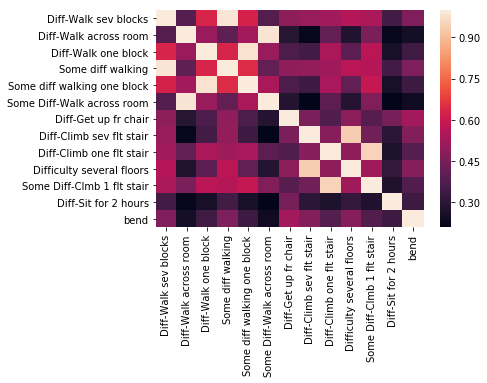

In [36]:
# heat map of correlations
sns.heatmap(corr)

In [37]:
X.describe()

,Diff-Walk sev blocks,Diff-Walk across room,Diff-Walk one block,Some diff walking,Some diff walking one block,Some Diff-Walk across room,Diff-Get up fr chair,Diff-Climb sev flt stair,Diff-Climb one flt stair,Difficulty several floors,Some Diff-Clmb 1 flt stair,Diff-Sit for 2 hours,bend
count,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000
mean,0.317286,0.078339,0.161252,0.323912,0.167058,0.081037,0.394277,0.451566,0.186642,0.484461,0.203061,0.209452,0.454556
std,0.465434,0.268713,0.367774,0.467981,0.373038,0.272899,0.488709,0.497663,0.389636,0.499773,0.402289,0.406930,0.497945
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
#initialize k-means function
#set number of clusters to categorize = 3
kmeans = KMeans(n_clusters=3)

#the model will learn which data points seem similar
#calculates centroids
#classfies data points in clusters based on distance to centroids
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [39]:
np.set_printoptions(precision=2,suppress=True)

In [40]:
#data point coordinates for centroids of each cluster
print(kmeans.cluster_centers_)

[[0.98 0.35 0.76 1.   0.78 0.36 0.82 0.86 0.73 0.96 0.79 0.46 0.86]
 [0.04 0.   0.   0.05 0.01 0.   0.15 0.   0.   0.01 0.   0.07 0.21]
 [0.32 0.01 0.   0.32 0.   0.01 0.52 0.97 0.12 0.99 0.12 0.26 0.6 ]]


In [41]:
#add a new column to dataframe called "clus_temp" of predicted clauter values
X['clus_temp'] = kmeans.labels_

C:\Users\kdpan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [42]:
# remap cluster numbers in order of high mobility =0, reduced mobility=1 low mobility=2
clus_dict = {0:0, 1:2, 2:1}
X['cluster'] = X['clus_temp'].replace(clus_dict)

C:\Users\kdpan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:
X['cluster'].value_counts()

2    8690
1    4783
0    3581
Name: cluster, dtype: int64

In [43]:
X.describe()

,Diff-Walk sev blocks,Diff-Walk across room,Diff-Walk one block,Some diff walking,Some diff walking one block,Some Diff-Walk across room,Diff-Get up fr chair,Diff-Climb sev flt stair,Diff-Climb one flt stair,Difficulty several floors,Some Diff-Clmb 1 flt stair,Diff-Sit for 2 hours,bend,clus_temp,cluster
count,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000
mean,0.317286,0.078339,0.161252,0.323912,0.167058,0.081037,0.394277,0.451566,0.186642,0.484461,0.203061,0.209452,0.454556,1.070482,1.299578
std,0.465434,0.268713,0.367774,0.467981,0.373038,0.272899,0.488709,0.497663,0.389636,0.499773,0.402289,0.406930,0.497945,0.696780,0.793617
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,2.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000


In [44]:
X.head()

,Diff-Walk sev blocks,Diff-Walk across room,Diff-Walk one block,Some diff walking,Some diff walking one block,Some Diff-Walk across room,Diff-Get up fr chair,Diff-Climb sev flt stair,Diff-Climb one flt stair,Difficulty several floors,Some Diff-Clmb 1 flt stair,Diff-Sit for 2 hours,bend,clus_temp,cluster
0,1,0,1,1,1,0,1,1,1,1,1,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
4,0,0,0,0,0,0,0,1,1,1,1,0,0,2,1


In [45]:
np.set_printoptions(precision=3,suppress=True)

### Set up data for model development

In [46]:
cluster_dummies = pd.get_dummies(X.cluster,prefix='cluster').iloc[:,1:]

In [47]:
cluster_dummies.columns

Index(['cluster_1', 'cluster_2'], dtype='object')

In [48]:
df_master2 = pd.concat([df_master,X['cluster'],cluster_dummies],axis=1)

In [49]:
df_master2.columns

Index(['ID', 'Debts', 'Total Wealth less IRA', 'Total Non-Housing Assets',
       'Total all Assets inc. 2nd Hm', 'Incm: Total HHold',
       'IS RECEIVING SSDI', 'Works at 2nd job', 'ragender',
       'Diff-Walk sev blocks', 'Diff-Walk across room', 'Diff-Walk one block',
       'Some diff walking', 'Some diff walking one block',
       'Some Diff-Walk across room', 'Diff-Get up fr chair',
       'Diff-Climb sev flt stair', 'Diff-Climb one flt stair',
       'Difficulty several floors', 'Some Diff-Clmb 1 flt stair',
       'Diff-Sit for 2 hours', 'bend', 'hi_emp', 'hi_gov', 'hi_medicare',
       'hi_va', 'has_life_ins', 'prob_live_to75', 'hh_size', 'age_months',
       'cluster', 'cluster_1', 'cluster_2'],
      dtype='object')

In [50]:
df_master2.describe()

,ID,Debts,Total Wealth less IRA,Total Non-Housing Assets,Total all Assets inc. 2nd Hm,Incm: Total HHold,IS RECEIVING SSDI,Works at 2nd job,ragender,Diff-Walk sev blocks,...,hi_gov,hi_medicare,hi_va,has_life_ins,prob_live_to75,hh_size,age_months,cluster,cluster_1,cluster_2
count,1.705400e+04,1.705400e+04,1.705400e+04,1.705400e+04,1.705400e+04,1.705400e+04,17054.000000,17054.000000,17054.000000,17054.000000,...,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000
mean,3.404089e+08,5.320011e+03,3.714383e+05,3.201123e+05,4.729873e+05,7.147094e+04,0.069661,0.045854,0.416852,0.317286,...,0.631113,0.573942,0.058637,0.574469,87.205707,2.319221,813.345022,1.299578,0.280462,0.509558
std,2.949931e+08,2.692382e+04,2.143587e+06,2.138704e+06,2.640174e+06,1.498852e+05,0.254582,0.209175,0.493052,0.465434,...,0.482517,0.494517,0.234951,0.494438,10.037317,1.304471,132.182303,0.793617,0.449238,0.499923
min,3.020000e+03,0.000000e+00,-2.751000e+06,-1.454500e+06,-2.729000e+06,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,64.984886,1.000000,226.000000,0.000000,0.000000,0.000000
25%,6.106503e+07,0.000000e+00,1.600000e+04,2.500000e+03,2.000000e+04,1.993400e+04,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,79.974364,2.000000,708.000000,1.000000,0.000000,0.000000
50%,2.111635e+08,0.000000e+00,1.174793e+05,3.240000e+04,1.420000e+05,4.200000e+04,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,85.107942,2.000000,793.000000,2.000000,0.000000,1.000000
75%,5.252320e+08,2.000000e+03,3.340000e+05,2.386000e+05,4.550000e+05,8.234175e+04,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,100.000000,3.000000,912.000000,2.000000,1.000000,1.000000
max,9.597380e+08,1.500000e+06,2.450000e+08,2.449000e+08,3.081000e+08,1.100285e+07,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,100.000000,15.000000,1233.000000,2.000000,1.000000,1.000000


In [51]:
print(df_master2.shape)
df_master2.dtypes

(17054, 33)


ID                                int64
Debts                           float64
Total Wealth less IRA           float64
Total Non-Housing Assets        float64
Total all Assets inc. 2nd Hm    float64
Incm: Total HHold               float64
IS RECEIVING SSDI                 int64
Works at 2nd job                float64
ragender                          int32
Diff-Walk sev blocks              int32
Diff-Walk across room             int32
Diff-Walk one block               int32
Some diff walking                 int32
Some diff walking one block       int32
Some Diff-Walk across room        int32
Diff-Get up fr chair              int32
Diff-Climb sev flt stair          int32
Diff-Climb one flt stair          int32
Difficulty several floors         int32
Some Diff-Clmb 1 flt stair        int32
Diff-Sit for 2 hours              int32
bend                              int32
hi_emp                          float64
hi_gov                          float64
hi_medicare                     float64


###  Model estimation
#####  Linear Regression using skelearn and statsmodel
#####  Logistics Regression

In [52]:
#assign linear regression function to a variable
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [53]:
Y = df_master2['Incm: Total HHold']

In [54]:
X1 = df_master2.drop(['ID', 'Debts', 'Total Wealth less IRA', 'Total Non-Housing Assets',
       'Total all Assets inc. 2nd Hm', 'Incm: Total HHold','IS RECEIVING SSDI',
                      'hi_medicare','hi_va',
                      'cluster','cluster_1','cluster_2'],axis=1)

In [55]:
results = lm.fit(X1, Y)
print('Estimated intercept coefficient:', lm.intercept_)
print('Number of coefficients:', len(lm.coef_))
print('R-squared:',lm.score(X1,Y))
pd.DataFrame(list(zip(X1.columns, lm.coef_)), columns = ['features', 'estimatedCoefficients'])

Estimated intercept coefficient: 92267.22594279924
Number of coefficients: 21
R-squared: 0.0539339507251102


,features,estimatedCoefficients
0,Works at 2nd job,47397.816495
1,ragender,9688.684839
2,Diff-Walk sev blocks,-2740.627803
3,Diff-Walk across room,2643.994297
4,Diff-Walk one block,299.177842
5,Some diff walking,-7076.579723
6,Some diff walking one block,1371.691318
7,Some Diff-Walk across room,-3720.394763
8,Diff-Get up fr chair,-2970.577886
9,Diff-Climb sev flt stair,3160.783148


In [56]:
X2 = X1.drop(['Diff-Sit for 2 hours','Diff-Get up fr chair', 
       'Some diff walking',
       'Some diff walking one block', 'Difficulty several floors',
       'Some Diff-Clmb 1 flt stair', 'Some Diff-Walk across room'],axis=1)
#'Diff-Walk across room',   
#'Diff-Walk sev blocks', 'Diff-Walk one block', 'Diff-Sit for 2 hours',       'Diff-Get up fr chair', 'Diff-Climb sev flt stair',
 #      'Diff-Climb one flt stair', 'bend', 'Some diff walking',
  #     'Some diff walking one block', 'Difficulty several floors',
   #    'Some Diff-Clmb 1 flt stair', 'Some Diff-Walk across room', 'cluster'

In [57]:
results1 = lm.fit(X2, Y)
print('Estimated intercept coefficient:', lm.intercept_)
print('Number of coefficients:', len(lm.coef_))
print('R-squared:',lm.score(X2,Y))
pd.DataFrame(list(zip(X2.columns, lm.coef_)), columns = ['features', 'estimatedCoefficients'])

Estimated intercept coefficient: 85946.29049707677
Number of coefficients: 14
R-squared: 0.052353792971530644


,features,estimatedCoefficients
0,Works at 2nd job,48197.351711
1,ragender,10650.081713
2,Diff-Walk sev blocks,-13685.509327
3,Diff-Walk across room,-4776.734320
4,Diff-Walk one block,917.719925
5,Diff-Climb sev flt stair,-17077.558427
6,Diff-Climb one flt stair,-2263.751678
7,bend,-6298.720922
8,hi_emp,23476.904101
9,hi_gov,-14271.884166


In [58]:
X3 = df_master2[['ragender','hi_emp', 'hi_gov','has_life_ins', 'prob_live_to75', 'hh_size','age_months',
                 'cluster_1','cluster_2']]

In [59]:
results1 = lm.fit(X3, Y)
print('Estimated intercept coefficient:', lm.intercept_)
print('Number of coefficients:', len(lm.coef_))
print('R-squared:',lm.score(X3,Y))
pd.DataFrame(list(zip(X3.columns, lm.coef_)), columns = ['features', 'estimatedCoefficients'])

Estimated intercept coefficient: 57101.14093070074
Number of coefficients: 9
R-squared: 0.04740265253150033


,features,estimatedCoefficients
0,ragender,10277.714911
1,hi_emp,24688.845430
2,hi_gov,-17062.287119
3,has_life_ins,23542.252607
4,prob_live_to75,-8.541810
5,hh_size,185.951309
6,age_months,-25.457567
7,cluster_1,10070.228337
8,cluster_2,36687.400285


In [60]:
import statsmodels.api as sm

import statsmodels.formula.api as smf

In [61]:
model1 = sm.OLS(Y, sm.add_constant(X1)).fit()

In [62]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Incm: Total HHold   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     46.24
Date:                Fri, 10 May 2019   Prob (F-statistic):          1.56e-186
Time:                        06:14:46   Log-Likelihood:            -2.2697e+05
No. Observations:               17054   AIC:                         4.540e+05
Df Residuals:                   17032   BIC:                         4.542e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        9.227e+04   1.47e+04      6.294      0.000    6.35e+04    1.21e+05
Works at 2nd job              4.74e+04   5459.510      8.682      0.000    3.67e+04    5.81e+04
ragender                     9688.6848   2797.742      3.463      0.001    4204.821    1.52e+04
Diff-Walk sev blocks        -2740.6278   1.83e+04     -0.150      0.881   -3.86e+04    3.31e+04
Diff-Walk across room        2643.9943   2.55e+04      0.104      0.917   -4.73e+04    5.26e+04
Diff-Walk one block           299.1778   2.09e+04      0.014      0.989   -4.07e+04    4.13e+04
Some diff walking           -7076.5797   1.85e+04     -0.383      0.702   -4.33e+04    2.92e+04
Some diff walking one block  1371.6913   2.12e+04      0.065      0.948   -4.01e+04    4.29e+04
Some Diff-Walk across room  -3720.3948   2.57e+04     -0.145      0.885   -5.41e+04    4.66e+04
Diff-Get up fr chair        -2970.5779   3044.701     -0.976      0.329   -8938.506    2997.350
Diff-Climb sev flt stair     3160.7831   8021.249      0.394      0.694   -1.26e+04    1.89e+04
Diff-Climb one flt stair     1367.3719   1.18e+04      0.115      0.908   -2.18e+04    2.46e+04
Difficulty several floors   -2.203e+04   8347.716     -2.639      0.008   -3.84e+04   -5667.830
Some Diff-Clmb 1 flt stair  -3380.9565   1.21e+04     -0.279      0.780   -2.71e+04    2.04e+04
Diff-Sit for 2 hours        -9912.2560   3177.448     -3.120      0.002   -1.61e+04   -3684.130
bend                        -3721.3833   2855.355     -1.303      0.192   -9318.175    1875.408
hi_emp                       2.305e+04   2823.183      8.164      0.000    1.75e+04    2.86e+04
hi_gov                      -1.308e+04   3358.732     -3.894      0.000   -1.97e+04   -6494.109
has_life_ins                 2.272e+04   2356.966      9.640      0.000    1.81e+04    2.73e+04
prob_live_to75                -22.5743    315.386     -0.072      0.943    -640.763     595.614
hh_size                       313.3362    893.473      0.351      0.726   -1437.963    2064.635
age_months                    -23.7886     23.029     -1.033      0.302     -68.928      21.351
==============================================================================
Omnibus:                    45733.644   Durbin-Watson:                   1.471
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2747976155.876
Skew:                          32.216   Prob(JB):                         0.00
Kurtosis:                    1968.467   Cond. No.                     2.87e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.87e+04. This might indicate that there are
strong multicollinearity o

In [63]:
model2 = sm.OLS(Y, sm.add_constant(X2)).fit()

In [64]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Incm: Total HHold   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     67.24
Date:                Fri, 10 May 2019   Prob (F-statistic):          1.21e-186
Time:                        06:14:46   Log-Likelihood:            -2.2698e+05
No. Observations:               17054   AIC:                         4.540e+05
Df Residuals:                   17039   BIC:                         4.541e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     8.595e+04   1.46e+04      5.894      0.000    5.74e+04    1.15e+05
Works at 2nd job           4.82e+04   5460.737      8.826      0.000    3.75e+04    5.89e+04
ragender                  1.065e+04   2787.334      3.821      0.000    5186.620    1.61e+04
Diff-Walk sev blocks     -1.369e+04   3528.514     -3.879      0.000   -2.06e+04   -6769.258
Diff-Walk across room    -4776.7343   4960.375     -0.963      0.336   -1.45e+04    4946.112
Diff-Walk one block        917.7199   4400.821      0.209      0.835   -7708.343    9543.783
Diff-Climb sev flt stair -1.708e+04   2859.224     -5.973      0.000   -2.27e+04   -1.15e+04
Diff-Climb one flt stair -2263.7517   3789.604     -0.597      0.550   -9691.766    5164.262
bend                     -6298.7209   2691.632     -2.340      0.019   -1.16e+04   -1022.844
hi_emp                    2.348e+04   2823.431      8.315      0.000    1.79e+04     2.9e+04
hi_gov                   -1.427e+04   3351.591     -4.258      0.000   -2.08e+04   -7702.419
has_life_ins              2.308e+04   2355.501      9.799      0.000    1.85e+04    2.77e+04
prob_live_to75              50.3647    315.025      0.160      0.873    -567.116     667.846
hh_size                    255.4685    893.892      0.286      0.775   -1496.652    2007.588
age_months                 -26.1771     22.882     -1.144      0.253     -71.028      18.674
==============================================================================
Omnibus:                    45698.395   Durbin-Watson:                   1.468
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2730742804.444
Skew:                          32.151   Prob(JB):                         0.00
Kurtosis:                    1962.292   Cond. No.                     1.09e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
model3 = sm.OLS(Y, sm.add_constant(X3)).fit()

In [66]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Incm: Total HHold   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     94.24
Date:                Fri, 10 May 2019   Prob (F-statistic):          2.12e-172
Time:                        06:14:46   Log-Likelihood:            -2.2703e+05
No. Observations:               17054   AIC:                         4.541e+05
Df Residuals:                   17044   BIC:                         4.542e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            5.71e+04   1.46e+04      3.898      0.000    2.84e+04    8.58e+04
ragender        1.028e+04   2796.097      3.676      0.000    4797.076    1.58e+04
hi_emp          2.469e+04   2826.673      8.734      0.000    1.91e+04    3.02e+04
hi_gov         -1.706e+04   3345.807     -5.100      0.000   -2.36e+04   -1.05e+04
has_life_ins    2.354e+04   2358.567      9.982      0.000    1.89e+04    2.82e+04
prob_live_to75    -8.5418    315.158     -0.027      0.978    -626.283     609.200
hh_size          185.9513    895.915      0.208      0.836   -1570.134    1942.036
age_months       -25.4576     22.868     -1.113      0.266     -70.281      19.366
cluster_1       1.007e+04   3286.844      3.064      0.002    3627.675    1.65e+04
cluster_2       3.669e+04   3102.339     11.826      0.000    3.06e+04    4.28e+04
==============================================================================
Omnibus:                    45768.124   Durbin-Watson:                   1.467
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2761234374.305
Skew:                          32.280   Prob(JB):                         0.00
Kurtosis:                    1973.204   Cond. No.                     1.09e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
X_reg1=df_master2[['ragender','Debts','Total Wealth less IRA','Total Non-Housing Assets','Total all Assets inc. 2nd Hm',
                   'hi_emp', 'hi_gov','has_life_ins', 'prob_live_to75', 'hh_size','age_months',
                 'cluster_1','cluster_2']]

In [68]:
X_reg1.head()

,ragender,Debts,Total Wealth less IRA,Total Non-Housing Assets,Total all Assets inc. 2nd Hm,hi_emp,hi_gov,has_life_ins,prob_live_to75,hh_size,age_months,cluster_1,cluster_2
0,0,0.0,212000.0,9.200000e+05,1.070000e+06,0.0,1.0,0.0,100.000000,2,908,0,0
1,1,0.0,901500.0,1.500000e+03,9.015000e+05,0.0,1.0,0.0,96.754512,3,898,0,1
2,0,0.0,358000.0,8.000000e+03,3.580000e+05,0.0,1.0,0.0,81.582701,1,696,0,1
3,0,0.0,265000.0,1.013314e+06,1.913314e+06,0.0,1.0,0.0,88.661186,1,816,0,1
4,1,0.0,0.0,0.000000e+00,1.100000e+04,0.0,1.0,0.0,100.000000,1,917,1,0


In [69]:
#build logistic regression model
LogReg = LogisticRegression()

In [70]:
y1 = df_master2['Difficulty several floors']
X_train, X_test, y_train, y_test = train_test_split(X_reg1, y1, test_size=0.25, random_state=15)
LogReg.fit(X_train, y_train)
LogReg.score(X_train, y_train) # income & wealth vs 'Difficulty several floors'

C:\Users\kdpan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5941360437842064

In [71]:
y2 = df_master2['Diff-Walk sev blocks']
X_train, X_test, y_train, y_test = train_test_split(X_reg1, y2, test_size=0.25, random_state=15)
LogReg.fit(X_train, y_train)
LogReg.score(X_train, y_train) # income & wealth vs 'Diff-Walk sev blocks'

C:\Users\kdpan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6830336200156372

In [72]:
y3 = df_master2['Diff-Climb sev flt stair']
X_train, X_test, y_train, y_test = train_test_split(X_reg1, y3, test_size=0.25, random_state=15)
LogReg.fit(X_train, y_train)
LogReg.score(X_train, y_train) # income & wealth vs 'Diff-Climb sev flt stair'

C:\Users\kdpan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5925723221266614

In [73]:
y4 = df_master2['Some diff walking']
X_train, X_test, y_train, y_test = train_test_split(X_reg1, y4, test_size=0.25, random_state=15)
LogReg.fit(X_train, y_train)
LogReg.score(X_train, y_train) # income & wealth vs 'Some diff walking'

C:\Users\kdpan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6766223612197029

In [74]:
y5 = df_master2['IS RECEIVING SSDI']
X_train, X_test, y_train, y_test = train_test_split(X_reg1, y5, test_size=0.25, random_state=15)
LogReg.fit(X_train, y_train)
LogReg.score(X_train, y_train) # income & wealth vs 'IS RECEIVING SSDI'

C:\Users\kdpan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9301016419077405

In [75]:
z1 = df_master2['cluster']
MulLogReg = LogisticRegression(multi_class='multinomial',solver='lbfgs')
X_train, X_test, y_train, y_test = train_test_split(X_reg1, z1, test_size=0.25, random_state=15)
MulLogReg.fit(X_train, y_train)
MulLogReg.score(X_train, y_train) # income & wealth vs 'cluster'

C:\Users\kdpan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.5042220484753713